In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time
from matplotlib import pyplot as plt

In [3]:
pipline_train = transforms.Compose([
    #随机旋转图片
    transforms.RandomHorizontalFlip(),
    #将图片尺寸resize到32x32
    transforms.Resize((32,32)),
    #将图片转化为Tensor格式
    transforms.ToTensor(),
    #正则化(当模型出现过拟合的情况时，用来降低模型的复杂度)
    transforms.Normalize((0.1307,),(0.3081,))    
])
pipline_test = transforms.Compose([
    #将图片尺寸resize到32x32
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])
#下载数据集
train_set = datasets.MNIST(root="./data", train=True, download=True, transform=pipline_train)
test_set = datasets.MNIST(root="./data", train=False, download=True, transform=pipline_test)
#加载数据集
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [4]:
# 搭建LeNet-5神经网络结构，并定义前向传播的过程
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) 
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [5]:
#将定义好的网络结构搭载到GPU/CPU，并定义优化器
#创建模型，部署gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)
#定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
#定义训练过程
def train_runner(model, device, trainloader, optimizer, epoch):
    #训练模型, 启用 BatchNormalization 和 Dropout, 将BatchNormalization和Dropout置为True
    model.train()
    total = 0
    correct =0.0
    
    #enumerate迭代已加载的数据集,同时获取数据和数据下标
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        #把模型部署到device上
        inputs, labels = inputs.to(device), labels.to(device)
        #初始化梯度
        optimizer.zero_grad()
        #保存训练结果
        outputs = model(inputs)
        #计算损失和
        #多分类情况通常使用cross_entropy(交叉熵损失函数), 而对于二分类问题, 通常使用sigmod
        loss = F.cross_entropy(outputs, labels)
        #获取最大概率的预测结果
        #dim=1表示返回每一行的最大值对应的列下标
        predict = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predict == labels).sum().item()
        #反向传播
        loss.backward()
        #更新参数
        optimizer.step()
        if i % 1000 == 0:
            #loss.item()表示当前loss的数值
            print("Train Epoch{} \t Loss: {:.6f}, accuracy: {:.6f}%".format(epoch, loss.item(), 100*(correct/total)))
            Loss.append(loss.item())
            Accuracy.append(correct/total)
    return loss.item(), correct/total

In [7]:
#定义测试过程
def test_runner(model, device, testloader):
    #模型验证, 必须要写, 否则只要有输入数据, 即使不训练, 它也会改变权值
    #因为调用eval()将不启用 BatchNormalization 和 Dropout, BatchNormalization和Dropout置为False
    model.eval()
    #统计模型正确率, 设置初始值
    correct = 0.0
    test_loss = 0.0
    total = 0
    #torch.no_grad将不会计算梯度, 也不会进行反向传播
    with torch.no_grad():
        for data, label in testloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, label).item()
            predict = output.argmax(dim=1)
            #计算正确数量
            total += label.size(0)
            correct += (predict == label).sum().item()
        #计算损失值
        print("test_avarage_loss: {:.6f}, accuracy: {:.6f}%".format(test_loss/total, 100*(correct/total)))

start_time 2023-04-08 17:10:47
Train Epoch1 	 Loss: 2.294501, accuracy: 14.062500%
test_avarage_loss: 0.004087, accuracy: 95.900000%
end_time:  2023-04-08 17:12:12 

start_time 2023-04-08 17:12:12
Train Epoch2 	 Loss: 0.176578, accuracy: 95.312500%
test_avarage_loss: 0.002687, accuracy: 97.200000%
end_time:  2023-04-08 17:12:34 

start_time 2023-04-08 17:12:34
Train Epoch3 	 Loss: 0.378167, accuracy: 89.062500%
test_avarage_loss: 0.002174, accuracy: 97.880000%
end_time:  2023-04-08 17:13:00 

start_time 2023-04-08 17:13:00
Train Epoch4 	 Loss: 0.008896, accuracy: 100.000000%
test_avarage_loss: 0.002335, accuracy: 97.760000%
end_time:  2023-04-08 17:13:22 

start_time 2023-04-08 17:13:22
Train Epoch5 	 Loss: 0.030877, accuracy: 96.875000%
test_avarage_loss: 0.001973, accuracy: 97.900000%
end_time:  2023-04-08 17:13:44 

Finished Training


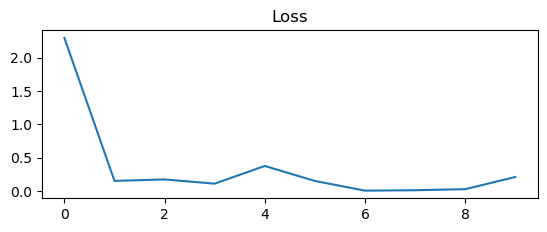

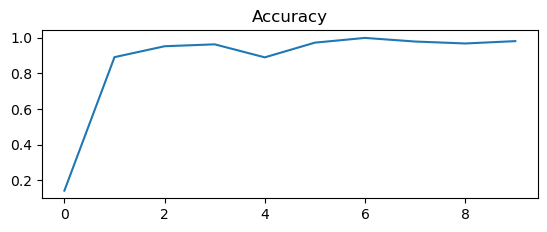

In [8]:
#运行调用
epoch = 5
Loss = []
Accuracy = []
for epoch in range(1, epoch+1):
    print("start_time",time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
    loss, acc = train_runner(model, device, trainloader, optimizer, epoch)
    Loss.append(loss)
    Accuracy.append(acc)
    test_runner(model, device, testloader)
    print("end_time: ",time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'\n')

print('Finished Training')
plt.subplot(2,1,1)
plt.plot(Loss)
plt.title('Loss')
plt.show()
plt.subplot(2,1,2)
plt.plot(Accuracy)
plt.title('Accuracy')
plt.show()

In [10]:
#保存模型
print(model)
torch.save(model, './models/model-mnist.pth') #保存模型

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


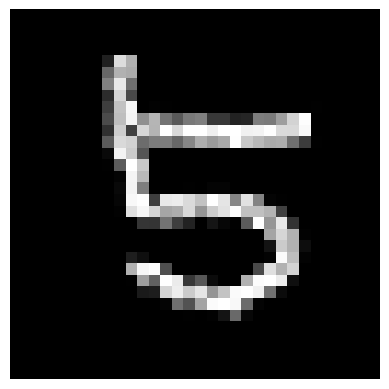

概率： tensor([[9.2848e-07, 3.4484e-07, 3.9148e-04, 9.6702e-05, 1.9926e-07, 9.9944e-01,
         3.5180e-06, 9.4873e-06, 4.1067e-05, 1.2477e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
预测类别： 5


In [13]:
import cv2

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torch.load('./models/model-mnist.pth') #加载模型
    model = model.to(device)
    model.eval()    #把模型转为test模式
    
    #读取要预测的图片
    img = cv2.imread("./images/test_mnist.jpg")
    img=cv2.resize(img,dsize=(32,32),interpolation=cv2.INTER_NEAREST)
    plt.imshow(img,cmap="gray") # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()
    
    # 导入图片，图片扩展后为[1，1，32，32]
    trans = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#图片转为灰度图，因为mnist数据集都是灰度图
    img = trans(img)
    img = img.to(device)
    img = img.unsqueeze(0)  #图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
   
    # 预测 
    output = model(img)
    prob = F.softmax(output,dim=1) #prob是10个分类的概率
    print("概率：",prob)
    value, predicted = torch.max(output.data, 1)
    predict = output.argmax(dim=1)
    print("预测类别：",predict.item())



In [12]:
pip install opencv-python


  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)
